# TensorFlow 2.0 alpha - Train Gradient Boosted Model using Decision Trees
### Boosted Trees are Ensemble techniques that work well for Regression and Classification 

## Load Titanic Dataset - Predict Passenger Survival

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output

# load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

import tensorflow as tf
tf.random.set_seed(123)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The dataset contains a training set and evaluation set - Training uses the following features:

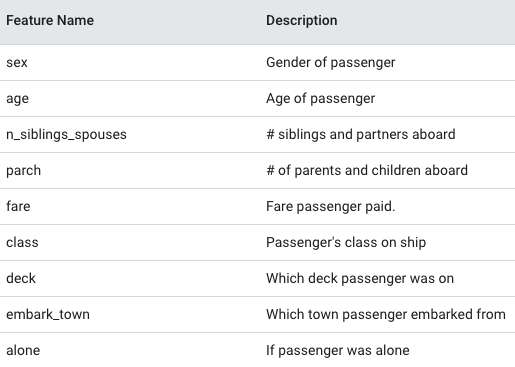

## Explore the Data

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

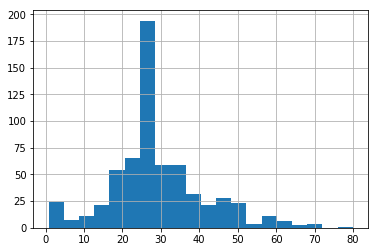

In [9]:
dftrain.age.hist(bins=20);

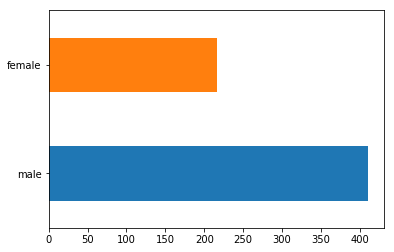

In [10]:
dftrain.sex.value_counts().plot(kind='barh');

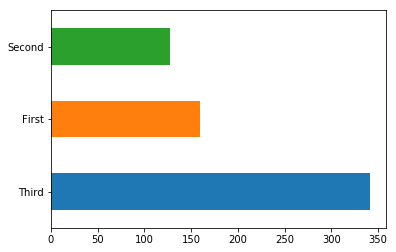

In [11]:
dftrain['class'].value_counts().plot(kind='barh');

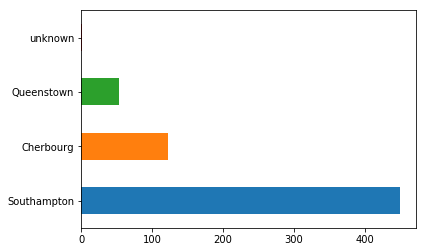

In [12]:
dftrain['embark_town'].value_counts().plot(kind='barh');

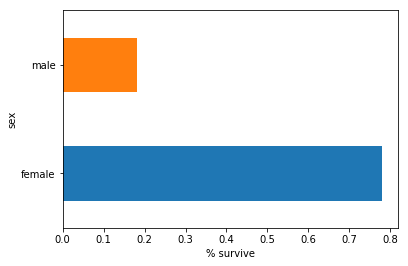

In [14]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive');

#### Most passengers are in their 20s and 30s - there are almost twice as many male as female - 3rd class contains the largest group - Most people embarked from Southhampton - Females have a much higher probability of survival

## Create Feature Columns and Input Functions
#### Gradient Boosting Estimators can utilitze both numeric and categorical features - Feature Columns provide capabilities like one-hot encoding, normalization, and bucketization
#### Transform Fields in CATEGORICAL_COLUMNS from categorical columns to one-hot-encoded (Indicator) columns

In [27]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                      'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                            vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                           dtype=tf.float64))

#### View the Feature Column Transformation - use the Indicator Column on a single example

In [28]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list('class', ('First','Second', 'Third')))

print('Feature Value: "{}"'.format(example['class'].iloc[0]))
print('One-hot Encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature Value: "Third"
One-hot Encoded:  [[0. 0. 1.]]


#### View all Feature Column Transformations

In [29]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

### Create Input Functions - how model reads data for training/inference
#### use from_tensor_slices - read in data directly from Pandas

In [32]:
# use entire batch for small dataset
# cycle through dataset in training as many times as needed - epochs=None

NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# INPUT FUNCTIONS

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, shuffle=False)

## Establish Benchmark with a Linear Classifier (logistic regression)

In [33]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# train
linear_est.train(train_input_fn, max_steps=100)

# evaluate
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


## Train and Evaluate Boosted Tree Model

In [35]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

# model will stop training when specified # of trees is built, not based on max steps

est.train(train_input_fn, max_steps=100)

result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.873003
auc_precision_recall      0.858218
average_loss              0.410594
label/mean                0.375000
loss                      0.410594
precision                 0.793478
prediction/mean           0.381616
recall                    0.737374
global_step             100.000000
dtype: float64


#### Use Model on the Evaluation Set

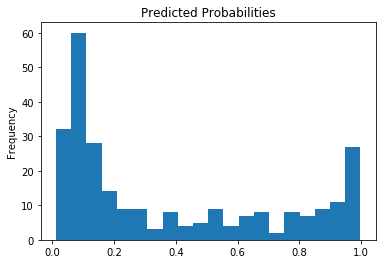

In [36]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Predicted Probabilities');

## View the receiver operating characteristic (ROC) of the results
#### Relationship between true positive and false positive rates

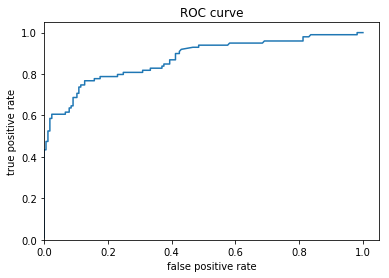

In [37]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0, )
plt.ylim(0, );

In [38]:
# image from tensorflow.org - Permissions granted